# Damped Spring Simulation and PINN Reconstruction

In this notebook we will:
- Simulate a damped spring system using a traditional numerical method.
- Visualize the time evolution of the damped spring system.
- Use a Physics-Informed Neural Network (PINN) to reconstruct the damped spring simulation.

## Damped Spring System

Consider a damped spring described by the ordinary differential equation (ODE):
$$
\ddot{x}(t) + c\,\dot{x}(t) + k\, x(t) = 0,
$$
where:
- $x(t)$ is the displacement,
- $c$ is the damping coefficient,
- $k$ is the spring constant.

For our simulation we will use:
- Mass $m = 1$ (so that the ODE is written in this form),
- Damping coefficient $c = 0.2$,
- Spring constant $k = 1$.

We will use the initial conditions:
- $x(0) = 1$ (initial displacement),
- $\dot{x}(0) = 0$ (initial velocity).

In the following cells we first simulate this system using a numerical integrator and then recreate it with a PINN.

Simulation complete.


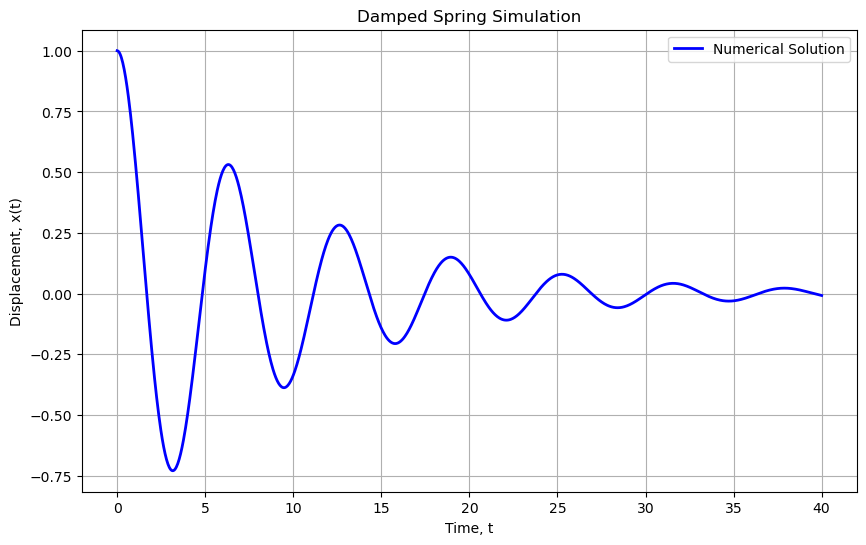

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import copy

# Define the damped spring ODE parameters
c = 0.2  # damping coefficient
k = 1.0  # spring constant

# Define the ODE system for the damped spring.
# Let y = [x, v] where v = dx/dt. Then:
#   dy/dt = [v, -c*v - k*x]
def damped_spring_ode(t, y):
    x, v = y
    return [v, -c * v - k * x]

# Initial conditions
x0 = 1.0
v0 = 0.0
y0 = [x0, v0]

# Time span for the simulation
t_span = (0, 40)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the ODE using solve_ivp (Runge-Kutta method)
sol = solve_ivp(damped_spring_ode, t_span, y0, t_eval=t_eval)

# Extract the time and displacement
t_sim = sol.t
x_sim = sol.y[0]

print("Simulation complete.")

# Plot the numerical simulation of the damped spring
plt.figure(figsize=(10, 6))
plt.plot(t_sim, x_sim, 'b-', lw=2, label='Numerical Solution')
plt.xlabel('Time, t')
plt.ylabel('Displacement, x(t)')
plt.title('Damped Spring Simulation')
plt.legend()
plt.grid(True)
plt.show()


## PINN Reconstruction of the Damped Spring System

We now aim to reconstruct the damped spring solution using a PINN that enforces the ODE
$$
x_{tt}(t) + c\, x_t(t) + k\, x(t) = 0,
$$
with the initial conditions $ x(0)=1 $ and $ x_t(0)=0 $.

**Training Setup:**
- **Training Domain:** $t \in [0, 30]$
- **Collocation Points:** We will sample a total of 500 points in $ t \in [0, 30] $ and split them into 80% for training and 20% for validation.
- **Extrapolation:** After training, we will evaluate the model on $t \in [0, 40]$ to test its extrapolation capability.

In the final visualization, we will overlay:
- The numerical solution (blue curve),
- The PINN solution (red dashed curve),
- Markers indicating the training and validation points.


In [2]:
# Import PyTorch libraries for the PINN
import torch
import torch.nn as nn
import torch.optim as optim

# MPS for Apple silicon userrs, change to cuda if you have nvidia gpus
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Define the PINN model: a fully connected network (MLP) that maps t -> x(t)
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, t):
        # t: tensor of shape (N, 1)
        for layer in self.layers[:-1]:
            t = self.activation(layer(t))
        t = self.layers[-1](t)
        return t

# Define network architecture: input (t) -> hidden layers -> output x(t)
layers = [1, 20, 20, 20, 1]
model = PINN(layers).to(device)


Using device: mps


In [3]:
# Define the PINN residual function for the damped spring ODE.
def pinn_residual(model, t):
    # Create a cloned version of t that requires gradient,
    # so that it works even if the original tensor is not set for gradient computation.
    t_ = t.clone().detach().requires_grad_(True)
    
    # Compute the prediction x(t)
    x = model(t_)
    
    # First derivative x_t = dx/dt
    x_t = torch.autograd.grad(x, t_, grad_outputs=torch.ones_like(x),
                              create_graph=True, retain_graph=True)[0]
    
    # Second derivative x_tt = d^2x/dt^2
    x_tt = torch.autograd.grad(x_t, t_, grad_outputs=torch.ones_like(x_t),
                               create_graph=True, retain_graph=True)[0]
    
    # Residual of the ODE: x_tt + c*x_t + k*x
    res = x_tt + c * x_t + k * x
    return res

# Define the loss function for the PINN.
def loss_function(model, t_collocation, t_ic, x_ic, v_ic):
    # ODE residual loss at collocation points
    res = pinn_residual(model, t_collocation)
    loss_res = torch.mean(res**2)
    
    # Use a version of t_ic with gradients enabled
    t_ic_grad = t_ic.clone().detach().requires_grad_(True)
    
    # Initial condition: x(0) = x_ic
    x_pred = model(t_ic_grad)
    loss_ic = torch.mean((x_ic - x_pred)**2)
    
    # Initial condition for derivative: x_t(0) = v_ic
    x_t_pred = torch.autograd.grad(x_pred, t_ic_grad, grad_outputs=torch.ones_like(x_pred),
                                   create_graph=True)[0]
    loss_ic_v = torch.mean((v_ic - x_t_pred)**2)
    
    return loss_res + loss_ic + loss_ic_v


In [4]:
# Prepare training and validation collocation points in t ∈ [0, 30]

N_total = 500
t_all = np.linspace(0, 30, N_total)[:, None]

# Randomly shuffle the indices and split into training and validation sets (80/20 split)
indices = np.random.permutation(N_total)
N_train = int(0.8 * N_total)
train_idx = indices[:N_train]
val_idx = indices[N_train:]

t_train = t_all[train_idx]
t_val = t_all[val_idx]

# Convert to PyTorch tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32, device=device)
t_val_tensor = torch.tensor(t_val, dtype=torch.float32, device=device)

# Initial condition (at t=0) remains the same: x(0)=1, x_t(0)=0.
t_ic = torch.tensor([[0.0]], dtype=torch.float32, device=device)
x_ic = torch.tensor([[1.0]], dtype=torch.float32, device=device)
v_ic = torch.tensor([[0.0]], dtype=torch.float32, device=device)

print("Training points:", t_train.shape, "Validation points:", t_val.shape)

# Train the PINN on the training collocation points (t in [0,30])
checkpoints = []    # each element will be a dictionary: {"epoch": epoch, "state_dict": ...}
checkpoint_interval = 1000  # save every 1000 epochs

optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20000

for epoch in range(epochs):
    optimizer.zero_grad()
    loss_train = loss_function(model, t_train_tensor, t_ic, x_ic, v_ic)
    loss_train.backward()
    optimizer.step()
    
    # Compute validation loss (without using no_grad() so that we get gradients for the residual)
    loss_val = loss_function(model, t_val_tensor, t_ic, x_ic, v_ic)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Training Loss = {loss_train.item():.6f}, Validation Loss = {loss_val.item():.6f}")
        # Save a deep copy of the current model parameters as a checkpoint
        cp = {"epoch": epoch, "state_dict": copy.deepcopy(model.state_dict())}
        checkpoints.append(cp)

Training points: (400, 1) Validation points: (100, 1)
Epoch 0: Training Loss = 0.798577, Validation Loss = 0.752753
Epoch 1000: Training Loss = 0.005221, Validation Loss = 0.011231
Epoch 2000: Training Loss = 0.003601, Validation Loss = 0.006910
Epoch 3000: Training Loss = 0.002889, Validation Loss = 0.005286
Epoch 4000: Training Loss = 0.002455, Validation Loss = 0.004084
Epoch 5000: Training Loss = 0.002051, Validation Loss = 0.002875
Epoch 6000: Training Loss = 0.001878, Validation Loss = 0.002449
Epoch 7000: Training Loss = 0.001715, Validation Loss = 0.001993
Epoch 8000: Training Loss = 0.001624, Validation Loss = 0.001824
Epoch 9000: Training Loss = 0.001549, Validation Loss = 0.001724
Epoch 10000: Training Loss = 0.001498, Validation Loss = 0.001682
Epoch 11000: Training Loss = 0.001458, Validation Loss = 0.001646
Epoch 12000: Training Loss = 0.001461, Validation Loss = 0.001679
Epoch 13000: Training Loss = 0.001400, Validation Loss = 0.001616
Epoch 14000: Training Loss = 0.0013

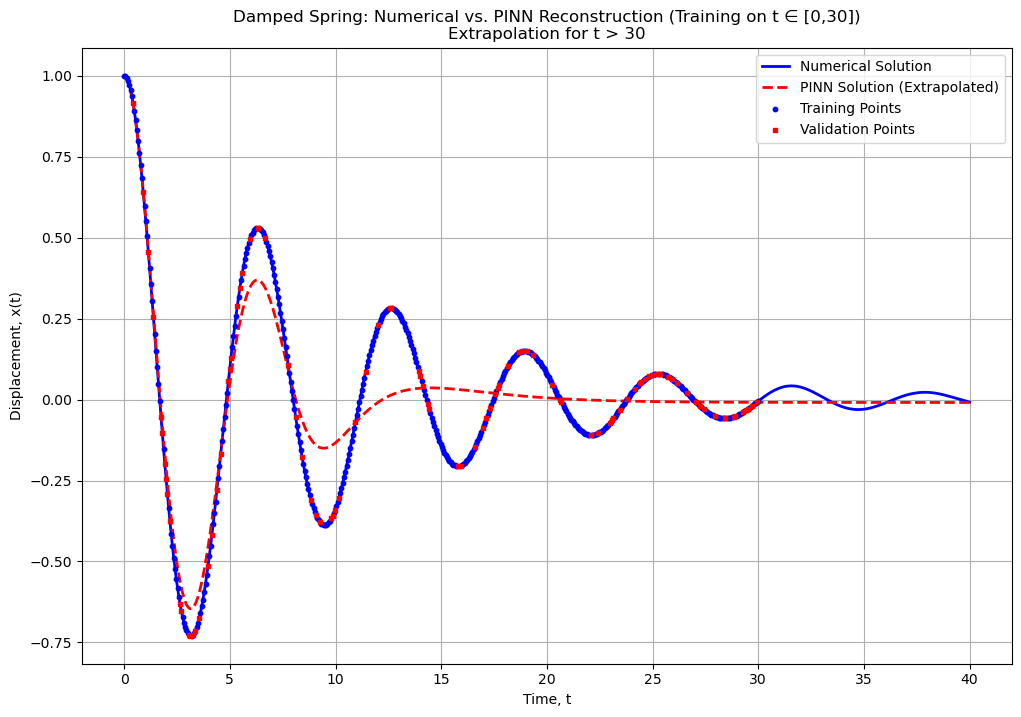

In [7]:
# Evaluate PINN model on t ∈ [0, 40]
t_eval_pinn = np.linspace(0, 40, 1000)[:, None]
t_eval_tensor = torch.tensor(t_eval_pinn, dtype=torch.float32, device=device)

with torch.no_grad():
    x_pinn = model(t_eval_tensor)
x_pinn = x_pinn.cpu().numpy().flatten()

# For plotting training/validation points, sort by time.
t_train_sorted = np.sort(t_train.flatten())
t_val_sorted = np.sort(t_val.flatten())

plt.figure(figsize=(12, 8))
plt.plot(t_sim, x_sim, 'b-', lw=2, label='Numerical Solution')
plt.plot(t_eval_pinn, x_pinn, 'r--', lw=2, label='PINN Solution (Extrapolated)')

# Mark training points on t in [0,30] (using numerical solution for y-values)
plt.scatter(t_train_sorted, np.interp(t_train_sorted, t_sim, x_sim), color='blue', 
            marker='o', s=10, label='Training Points', zorder=5)
# Mark validation points on t in [0,30]
plt.scatter(t_val_sorted, np.interp(t_val_sorted, t_sim, x_sim), color='red', 
            marker='s', s=10, label='Validation Points', zorder=5)

plt.xlabel('Time, t')
plt.ylabel('Displacement, x(t)')
plt.title('Damped Spring: Numerical vs. PINN Reconstruction (Training on t ∈ [0,30])\nExtrapolation for t > 30')
plt.legend()
plt.grid(True)
plt.show()


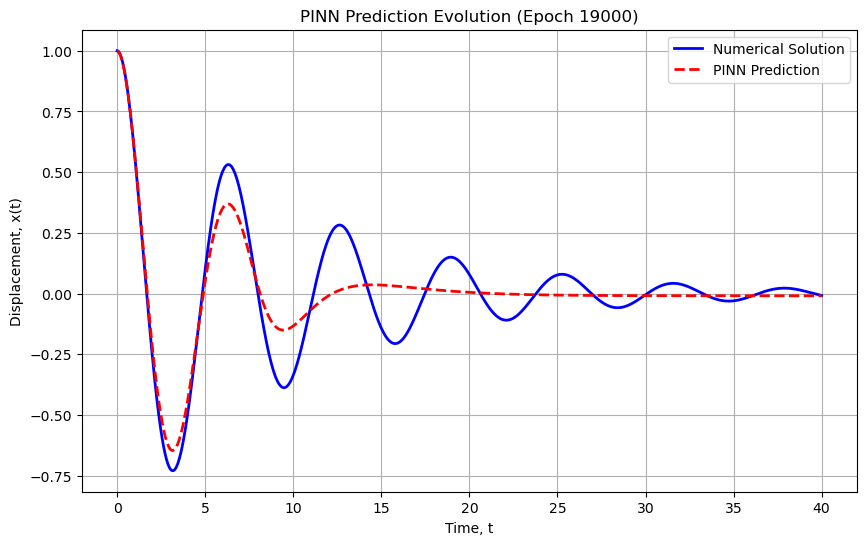

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter

# Evaluation grid (over full domain t ∈ [0, 40])
t_eval_pinn = np.linspace(0, 40, 1000)[:, None]
t_eval_tensor = torch.tensor(t_eval_pinn, dtype=torch.float32, device=device)

# Create a list to store predictions from each checkpoint
predictions_over_training = []
epoch_list = []

# Loop over saved checkpoints, load the model state, and compute the prediction
for cp in checkpoints:
    epoch_list.append(cp["epoch"])
    model.load_state_dict(cp["state_dict"])
    with torch.no_grad():
        x_pred_cp = model(t_eval_tensor).cpu().numpy().flatten()
    predictions_over_training.append(x_pred_cp)

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the numerical solution as a reference
ax.plot(t_sim, x_sim, 'b-', lw=2, label='Numerical Solution')

# Create a line for the PINN prediction (this will be updated)
line_pred, = ax.plot(t_eval_pinn, predictions_over_training[0], 'r--', lw=2, label='PINN Prediction')

ax.set_xlabel('Time, t')
ax.set_ylabel('Displacement, x(t)')
ax.set_title(f'PINN Prediction Evolution (Epoch {epoch_list[0]})')
ax.legend()
ax.grid(True)

# Update function for animation: update the line with predictions from each checkpoint
def update(frame):
    line_pred.set_ydata(predictions_over_training[frame])
    ax.set_title(f'PINN Prediction Evolution (Epoch {epoch_list[frame]})')
    return line_pred,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(checkpoints), interval=200, blit=False)

# %matplotlib ipympl

# Save the animation as a GIF
writer = PillowWriter(fps=2)
ani.save("pinn_spring_evolution.gif", writer=writer)
plt.show()


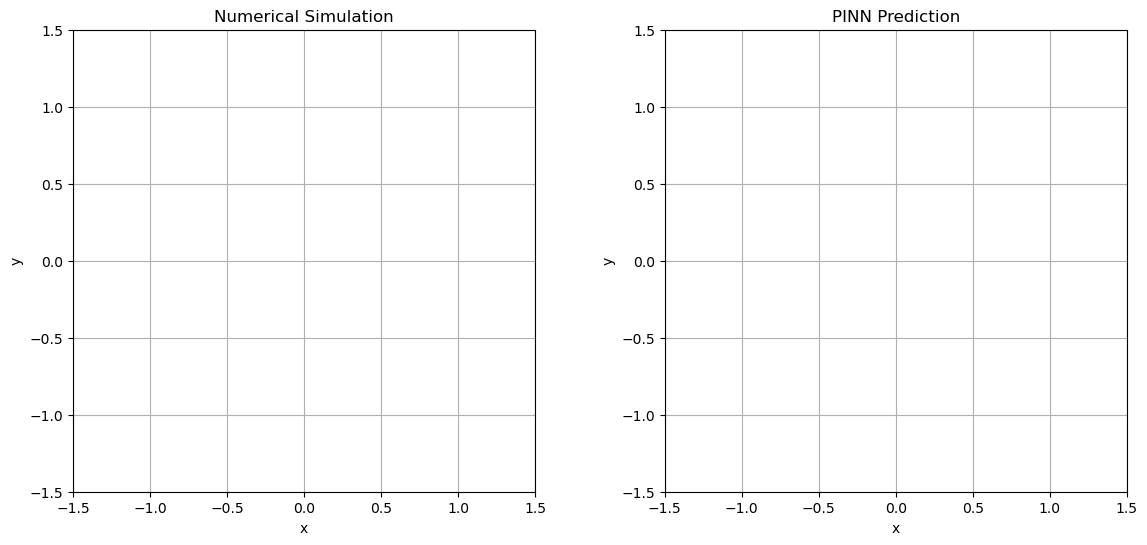

Animation saved as damped_spring_vertical_animation.gif


In [15]:
import matplotlib.animation as animation



def get_vertical_spring_line(y_mass, anchor_y=1.5, num_points=50, amplitude=0.1, coils=4):
    """
    Generate x and y coordinates for a vertical spring.
    
    The fixed anchor is at (0, anchor_y) and the mass is at (0, y_mass).
    The spring is drawn as a straight line from the anchor to the mass with
    a horizontal sinusoidal oscillation added.
    
    Parameters:
      y_mass   : The vertical coordinate of the mass.
      anchor_y : The vertical coordinate of the fixed anchor.
      num_points: Number of points along the spring line.
      amplitude: Amplitude of horizontal oscillation.
      coils    : Number of complete oscillation cycles.
      
    Returns:
      x_line, y_line : Arrays with the x and y coordinates of the spring.
    """
    # Define the anchor point A and mass point M
    A = np.array([0, anchor_y])
    M = np.array([0, y_mass])
    
    # Parameter s varies from 0 (at A) to 1 (at M)
    s = np.linspace(0, 1, num_points)
    
    # Linear interpolation between A and M
    x_lin = np.zeros_like(s)  # Since both have x=0
    y_lin = (1 - s) * A[1] + s * M[1]
    
    # Add a horizontal oscillation to create the spring effect.
    # Oscillation is added perpendicular to the vertical direction.
    x_offset = amplitude * np.sin(2 * np.pi * coils * s)
    
    # The final spring coordinates: x offset plus the linear x (which is 0), y from the linear interpolation.
    x_line = x_lin + x_offset
    y_line = y_lin
    return x_line, y_line

# Set up the figure with two subplots: one for the numerical solution and one for the PINN prediction.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Set axes limits and labels (mass moves along the y-axis)
for ax in (ax1, ax2):
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)

ax1.set_title('Numerical Simulation')
ax2.set_title('PINN Prediction')

# Initialize the spring line and mass marker for each subplot.
line_spring_num, = ax1.plot([], [], 'k-', lw=2)
marker_num, = ax1.plot([], [], 'bo', markersize=12)
line_spring_pinn, = ax2.plot([], [], 'k-', lw=2)
marker_pinn, = ax2.plot([], [], 'ro', markersize=12)

def init():
    line_spring_num.set_data([], [])
    marker_num.set_data([], [])
    line_spring_pinn.set_data([], [])
    marker_pinn.set_data([], [])
    return line_spring_num, marker_num, line_spring_pinn, marker_pinn

def update(frame):
    # Get the vertical displacement for the current frame
    # Here, we interpret x_sim (and x_pinn) as the mass's vertical position y.
    y_num = x_sim[frame]         # Numerical simulation result (vertical position)
    y_pinn = x_pinn[frame]         # PINN prediction (vertical position)
    
    # Use a fixed anchor at (0, anchor_y). For example, set anchor_y = 1.5.
    anchor_y = 1.5

    # Generate spring line coordinates for each solution.
    xs_num, ys_num = get_vertical_spring_line(y_num, anchor_y=anchor_y, num_points=50, amplitude=0.1, coils=4)
    xs_pinn, ys_pinn = get_vertical_spring_line(y_pinn, anchor_y=anchor_y, num_points=50, amplitude=0.1, coils=4)
    
    # Update the numerical subplot.
    line_spring_num.set_data(xs_num, ys_num)
    marker_num.set_data([0], [y_num])  # mass at (0, y_num)
    ax1.set_title(f'Numerical Simulation (t = {t_sim[frame]:.2f})')
    
    # Update the PINN subplot.
    line_spring_pinn.set_data(xs_pinn, ys_pinn)
    marker_pinn.set_data([0], [y_pinn])  # mass at (0, y_pinn)
    ax2.set_title(f'PINN Prediction (t = {t_sim[frame]:.2f})')
    
    return line_spring_num, marker_num, line_spring_pinn, marker_pinn

# Create the animation.
# Assumes that t_sim, x_sim, and x_pinn all have the same length.
ani = animation.FuncAnimation(fig, update, frames=len(t_sim),
                              init_func=init, interval=30, blit=True)

plt.show()

# Optionally, save the animation as a GIF.
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=30)
ani.save("damped_spring_vertical_animation.gif", writer=writer)
print("Animation saved as damped_spring_vertical_animation.gif")